In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_samples, silhouette_score
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### read files

#### campaign desc

In [2]:
camp_desc = pd.read_csv('campaign_desc.csv')

In [3]:
camp_desc.head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


In [4]:
len(camp_desc)

30

#### campaign table

In [5]:
camp_table = pd.read_csv('campaign_table.csv')

In [6]:
camp_table.head()

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


In [7]:
len(camp_table)

7208

#### causal data

In [8]:
causal = pd.read_csv('causal_data.csv')

In [9]:
causal.head()

,PRODUCT_ID,STORE_ID,WEEK_NO,display,mailer
0,26190,286,70,0,A
1,26190,288,70,0,A
2,26190,289,70,0,A
3,26190,292,70,0,A
4,26190,293,70,0,A


In [10]:
len(causal)

36786524

#### coupon

In [11]:
coupon = pd.read_csv('coupon.csv')

In [12]:
coupon.head()

,COUPON_UPC,PRODUCT_ID,CAMPAIGN
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


In [13]:
len(coupon)

124548

#### coupon redempt

In [14]:
coupon_redmpt = pd.read_csv('coupon_redempt.csv')

In [15]:
coupon_redmpt.head()

,household_key,DAY,COUPON_UPC,CAMPAIGN
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8
3,1,597,10000085476,18
4,1,597,54200029176,18


#### hh_demographic

In [16]:
hh_demog = pd.read_csv('hh_demographic.csv')

In [17]:
hh_demog.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [18]:
len(hh_demog)

801

#### product

In [19]:
product = pd.read_csv('product.csv')

In [20]:
product.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [21]:
len(product)

92353

#### transaction_data

In [22]:
transaction_data = pd.read_csv('transaction_data.csv')

In [23]:
transaction_data.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39000,364,-0.60000,1631,1,0.00000,0.00000
1,2375,26984851472,1,1033142,1,0.82000,364,0.00000,1631,1,0.00000,0.00000
2,2375,26984851472,1,1036325,1,0.99000,364,-0.30000,1631,1,0.00000,0.00000
3,2375,26984851472,1,1082185,1,1.21000,364,0.00000,1631,1,0.00000,0.00000
4,2375,26984851472,1,8160430,1,1.50000,364,-0.39000,1631,1,0.00000,0.00000


In [24]:
len(transaction_data)

2595732

#### comment : reading files finished 

### ***

## I will start from transaction data

### lets find unique households in transaction data

In [25]:
transaction_data['household_key'].nunique()

2500

### now, lets find if there is a zero quantity rows in our data, if there is , I will discard them

In [26]:
len(transaction_data[transaction_data['QUANTITY'] == 0])

14466

In [27]:
transaction_data2 = transaction_data[transaction_data['QUANTITY']!=0]

### calculate actual prices

In [28]:
transaction_data2['actual_product_price'] = np.where(transaction_data2['RETAIL_DISC']>0,
                                            (transaction_data2['SALES_VALUE'] - (transaction_data2['RETAIL_DISC'] - transaction_data2['COUPON_MATCH_DISC'])) / transaction_data2['QUANTITY'],
                                           np.where(transaction_data2['RETAIL_DISC']==0,
                                            (transaction_data2['SALES_VALUE'] - transaction_data2['COUPON_MATCH_DISC']) / transaction_data2['QUANTITY'],transaction_data2['SALES_VALUE']))

C:\Users\Hincal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [29]:
len(transaction_data2)

2581266

### find how many distinct product we have in our transaction data

In [30]:
transaction_data['PRODUCT_ID'].nunique()

92339

In [31]:
product['PRODUCT_ID'].nunique()

92353

In [32]:
len(transaction_data2[transaction_data2['PRODUCT_ID'].isin (product['PRODUCT_ID'])==True])

2581266

#### comment : it is good, we can merge transaction data with product data

### So lets merge !

In [33]:
transaction_data3 = pd.merge(transaction_data2,product,on='PRODUCT_ID',how='inner')

In [34]:
len(transaction_data3)

2581266

In [35]:
transaction_data3.isnull().sum()

household_key           0
BASKET_ID               0
DAY                     0
PRODUCT_ID              0
QUANTITY                0
SALES_VALUE             0
STORE_ID                0
RETAIL_DISC             0
TRANS_TIME              0
WEEK_NO                 0
COUPON_DISC             0
COUPON_MATCH_DISC       0
actual_product_price    0
MANUFACTURER            0
DEPARTMENT              0
BRAND                   0
COMMODITY_DESC          0
SUB_COMMODITY_DESC      0
CURR_SIZE_OF_PRODUCT    0
dtype: int64

In [36]:
transaction_data3.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,actual_product_price,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,2375,26984851472,1,1004906,1,1.39000,364,-0.60000,1631,1,0.00000,0.00000,1.39000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB
1,1929,27021022215,4,1004906,1,1.39000,441,-0.60000,1755,1,0.00000,0.00000,1.39000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB
2,568,27021090189,4,1004906,1,1.39000,446,-0.60000,35,1,0.00000,0.00000,1.39000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB
3,887,27031467254,5,1004906,1,1.39000,298,-0.60000,1551,1,0.00000,0.00000,1.39000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB
4,175,27057508267,7,1004906,1,1.99000,446,0.00000,2303,2,0.00000,0.00000,1.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB


### now I will merge transaction data with causal data

In [37]:
transaction_data4 = pd.merge(transaction_data3,causal,how='left',on=['PRODUCT_ID','STORE_ID','WEEK_NO'])

In [38]:
len(transaction_data4)

2582122

In [39]:
transaction_data4.isnull().sum()

household_key                 0
BASKET_ID                     0
DAY                           0
PRODUCT_ID                    0
QUANTITY                      0
SALES_VALUE                   0
STORE_ID                      0
RETAIL_DISC                   0
TRANS_TIME                    0
WEEK_NO                       0
COUPON_DISC                   0
COUPON_MATCH_DISC             0
actual_product_price          0
MANUFACTURER                  0
DEPARTMENT                    0
BRAND                         0
COMMODITY_DESC                0
SUB_COMMODITY_DESC            0
CURR_SIZE_OF_PRODUCT          0
display                 2018356
mailer                  2018356
dtype: int64

#### I will merge camp and camp desc tables now

In [40]:
camp_merged = pd.merge(camp_table,camp_desc,how='left',on=['CAMPAIGN','DESCRIPTION'])

In [41]:
len(camp_merged)

7208

In [42]:
camp_merged.head()

,DESCRIPTION,household_key,CAMPAIGN,START_DAY,END_DAY
0,TypeA,17,26,224,264
1,TypeA,27,26,224,264
2,TypeA,212,26,224,264
3,TypeA,208,26,224,264
4,TypeA,192,26,224,264


In [43]:
camp_merged.isnull().sum()

DESCRIPTION      0
household_key    0
CAMPAIGN         0
START_DAY        0
END_DAY          0
dtype: int64

### Now I will join transaction data with camp data

In [44]:
transaction_data4 = transaction_data4.set_index('household_key')
camp_merged = camp_merged.set_index('household_key')
transaction_data5 = pd.merge(transaction_data4,camp_merged,how='left',on='household_key',left_index=True,right_index=True)

In [45]:
transaction_data5.reset_index(inplace=True)

In [46]:
len(transaction_data4)

2582122

In [47]:
transaction_data5.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,actual_product_price,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,display,mailer,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,1,28744672720,137,1004906,1,1.79000,436,0.00000,2003,20,0.00000,0.00000,1.79000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264
1,1,29672186253,192,1004906,1,2.49000,436,0.00000,1422,28,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264
2,1,31624896613,311,1004906,1,2.99000,436,0.00000,1630,45,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264
3,1,31818756113,324,1004906,1,2.99000,436,0.00000,1426,47,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264
4,1,32259826179,361,1004906,1,2.49000,436,0.00000,1329,52,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264


In [48]:
transaction_data5.isnull().sum()

household_key                 0
BASKET_ID                     0
DAY                           0
PRODUCT_ID                    0
QUANTITY                      0
SALES_VALUE                   0
STORE_ID                      0
RETAIL_DISC                   0
TRANS_TIME                    0
WEEK_NO                       0
COUPON_DISC                   0
COUPON_MATCH_DISC             0
actual_product_price          0
MANUFACTURER                  0
DEPARTMENT                    0
BRAND                         0
COMMODITY_DESC                0
SUB_COMMODITY_DESC            0
CURR_SIZE_OF_PRODUCT          0
display                 2018356
mailer                  2018356
DESCRIPTION                   0
CAMPAIGN                      0
START_DAY                     0
END_DAY                       0
dtype: int64

### mark if transaction day is between campaign dates

In [49]:
transaction_data5['is_between_camp_dates'] = np.where((transaction_data5['DAY']>=transaction_data5['START_DAY']) & (transaction_data5['DAY']<=transaction_data5['END_DAY']),1,0)

In [50]:
transaction_data5.head(10)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,actual_product_price,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,display,mailer,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY,is_between_camp_dates
0,1,28744672720,137,1004906,1,1.79000,436,0.00000,2003,20,0.00000,0.00000,1.79000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
1,1,29672186253,192,1004906,1,2.49000,436,0.00000,1422,28,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
2,1,31624896613,311,1004906,1,2.99000,436,0.00000,1630,45,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
3,1,31818756113,324,1004906,1,2.99000,436,0.00000,1426,47,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
4,1,32259826179,361,1004906,1,2.49000,436,0.00000,1329,52,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
5,1,33409625841,436,1004906,1,2.99000,436,0.00000,1227,63,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,0,F,TypeA,26,224,264,0
6,1,36027807102,540,1004906,1,2.00000,436,-0.29000,1851,78,0.00000,0.00000,2.00000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,0,F,TypeA,26,224,264,0
7,1,40666800522,597,1004906,1,2.99000,436,0.00000,1125,86,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
8,1,41338185846,639,1004906,1,2.49000,436,0.00000,1230,92,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
9,1,41809641616,675,1004906,1,2.49000,436,0.00000,1640,97,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0


In [51]:
transaction_data5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2582122 entries, 0 to 2582121
Data columns (total 26 columns):
household_key            int64
BASKET_ID                int64
DAY                      int64
PRODUCT_ID               int64
QUANTITY                 int64
SALES_VALUE              float64
STORE_ID                 int64
RETAIL_DISC              float64
TRANS_TIME               int64
WEEK_NO                  int64
COUPON_DISC              float64
COUPON_MATCH_DISC        float64
actual_product_price     float64
MANUFACTURER             int64
DEPARTMENT               object
BRAND                    object
COMMODITY_DESC           object
SUB_COMMODITY_DESC       object
CURR_SIZE_OF_PRODUCT     object
display                  object
mailer                   object
DESCRIPTION              object
CAMPAIGN                 int64
START_DAY                int64
END_DAY                  int64
is_between_camp_dates    int32
dtypes: float64(5), int32(1), int64(12), object(8)
memory usage

#### to here it is ok *

### **

In [52]:
### for the memory issues
transaction_data2 = None
transaction_data3 = None
transaction_data4 = None

### Now I will find each household's daily-weekly aggregated buying information

### seg 1-) Identify buying behaviour

In [53]:
transaction_data5.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,actual_product_price,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,display,mailer,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY,is_between_camp_dates
0,1,28744672720,137,1004906,1,1.79000,436,0.00000,2003,20,0.00000,0.00000,1.79000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
1,1,29672186253,192,1004906,1,2.49000,436,0.00000,1422,28,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
2,1,31624896613,311,1004906,1,2.99000,436,0.00000,1630,45,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
3,1,31818756113,324,1004906,1,2.99000,436,0.00000,1426,47,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
4,1,32259826179,361,1004906,1,2.49000,436,0.00000,1329,52,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0


In [54]:
transaction_data5.columns.tolist()

['household_key',
 'BASKET_ID',
 'DAY',
 'PRODUCT_ID',
 'QUANTITY',
 'SALES_VALUE',
 'STORE_ID',
 'RETAIL_DISC',
 'TRANS_TIME',
 'WEEK_NO',
 'COUPON_DISC',
 'COUPON_MATCH_DISC',
 'actual_product_price',
 'MANUFACTURER',
 'DEPARTMENT',
 'BRAND',
 'COMMODITY_DESC',
 'SUB_COMMODITY_DESC',
 'CURR_SIZE_OF_PRODUCT',
 'display',
 'mailer',
 'DESCRIPTION',
 'CAMPAIGN',
 'START_DAY',
 'END_DAY',
 'is_between_camp_dates']

In [55]:
transaction_data5.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,actual_product_price,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,display,mailer,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY,is_between_camp_dates
0,1,28744672720,137,1004906,1,1.79000,436,0.00000,2003,20,0.00000,0.00000,1.79000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
1,1,29672186253,192,1004906,1,2.49000,436,0.00000,1422,28,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
2,1,31624896613,311,1004906,1,2.99000,436,0.00000,1630,45,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
3,1,31818756113,324,1004906,1,2.99000,436,0.00000,1426,47,0.00000,0.00000,2.99000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0
4,1,32259826179,361,1004906,1,2.49000,436,0.00000,1329,52,0.00000,0.00000,2.49000,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,TypeA,26,224,264,0


In [56]:
transaction_data5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2582122 entries, 0 to 2582121
Data columns (total 26 columns):
household_key            int64
BASKET_ID                int64
DAY                      int64
PRODUCT_ID               int64
QUANTITY                 int64
SALES_VALUE              float64
STORE_ID                 int64
RETAIL_DISC              float64
TRANS_TIME               int64
WEEK_NO                  int64
COUPON_DISC              float64
COUPON_MATCH_DISC        float64
actual_product_price     float64
MANUFACTURER             int64
DEPARTMENT               object
BRAND                    object
COMMODITY_DESC           object
SUB_COMMODITY_DESC       object
CURR_SIZE_OF_PRODUCT     object
display                  object
mailer                   object
DESCRIPTION              object
CAMPAIGN                 int64
START_DAY                int64
END_DAY                  int64
is_between_camp_dates    int32
dtypes: float64(5), int32(1), int64(12), object(8)
memory usage

In [57]:
transaction_data5['display'] = np.where(transaction_data5['display'].isin(['NaN','0']),0,0)
transaction_data5['mailer'] = np.where(transaction_data5['display'].isin(['NaN','0']),0,0)

C:\Users\Hincal\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [58]:
transaction_data5.DEPARTMENT

0          PRODUCE
1          PRODUCE
2          PRODUCE
3          PRODUCE
4          PRODUCE
            ...   
2582117    DRUG GM
2582118    SEAFOOD
2582119    DRUG GM
2582120    DRUG GM
2582121    GROCERY
Name: DEPARTMENT, Length: 2582122, dtype: object

In [59]:
transaction_data5.groupby(['household_key','DAY','WEEK_NO']).agg({'DEPARTMENT' : lambda x: pd.Series.value_counts(x)[1:2]})

DEPARTMENT
household_key DAY WEEK_NO           
1             51  8                4
              67  10               4
              88  13               2
              94  14               2
              101 15               2
...                              ...
2500          695 100              2
              698 100              3
              704 101              2
              706 102              1
              708 102              6

[225344 rows x 1 columns]

In [60]:
agg1 = transaction_data5.groupby(['household_key','DAY','WEEK_NO']).agg({
                                                       'BASKET_ID' : 'count',
                                                       'PRODUCT_ID': 'count',
                                                       'QUANTITY': 'mean',
                                                       'SALES_VALUE':'mean',
                                                       'STORE_ID' : 'nunique',
                                                       'RETAIL_DISC' : 'mean',
                                                       'TRANS_TIME': 'mean',
                                                       'actual_product_price' : 'mean',
                                                       'COUPON_DISC': 'mean',
                                                       'COUPON_MATCH_DISC': 'mean',
                                                       'DEPARTMENT' : lambda x: pd.Series.value_counts(x).index[0],
                                                       'BRAND' : lambda x: pd.Series.mode(x)[0],
                                                       'COMMODITY_DESC' : lambda x: pd.Series.mode(x)[0],
                                                       'DESCRIPTION' : lambda x: pd.Series.mode(x)[0],
                                                       'display' : 'sum',
                                                       'mailer' : 'sum',
                                                       'is_between_camp_dates' : 'sum'
                                                       
    
})

#agg1.columns = agg1.columns.droplevel(0)

agg1.columns = ['basket_cnt',
                'product_cnt',
                'avg_quantity',
                'avg_sales',
                'store_cnt',
                'retail_disc_mean',
                'avg_trans_time',
                'avg_actual_prod_price',
                'avg_coupon_disc',
                'avg_coup_mdisc',
                'most_freq_depart',
                'most_freq_brand',
                'most_freq_commodity',
                'most_freq_camp',
                'most_freq_display',
                'most_freq_mailer',
                'camp_date_exp'
               ]

agg1.reset_index(inplace=True)

agg1.head()

,household_key,DAY,WEEK_NO,basket_cnt,product_cnt,avg_quantity,avg_sales,store_cnt,retail_disc_mean,avg_trans_time,avg_actual_prod_price,avg_coupon_disc,avg_coup_mdisc,most_freq_depart,most_freq_brand,most_freq_commodity,most_freq_camp,most_freq_display,most_freq_mailer,camp_date_exp
0,1,51,8,30,30,1.13333,2.62200,1,-0.55133,1456.00000,2.58567,-0.03333,0.00000,GROCERY,National,FRUIT - SHELF STABLE,TypeA,0,0,0
1,1,67,10,11,11,1.27273,3.73636,1,-0.78091,2002.00000,3.49636,0.00000,0.00000,GROCERY,National,CANDY - PACKAGED,TypeA,0,0,0
2,1,88,13,12,12,1.08333,2.24167,1,-0.56000,1604.00000,2.24167,0.00000,0.00000,GROCERY,National,BAG SNACKS,TypeA,0,0,0
3,1,94,14,22,22,1.45455,2.88318,1,-0.50364,1937.00000,2.72045,-0.02273,-0.02273,GROCERY,National,DELI MEATS,TypeA,0,0,0
4,1,101,15,17,17,1.17647,3.14412,1,-0.96588,1603.00000,3.14412,0.00000,0.00000,GROCERY,National,BAKED BREAD/BUNS/ROLLS,TypeA,0,0,0


### I will create shifted week no column to find weekly buying interval

In [61]:
agg1['week_shifted'] = agg1.groupby('household_key')['WEEK_NO'].shift(1)

In [62]:
agg1['week_diff'] = agg1['WEEK_NO'] - agg1['week_shifted']

In [63]:
agg1.isnull().sum()

household_key               0
DAY                         0
WEEK_NO                     0
basket_cnt                  0
product_cnt                 0
avg_quantity                0
avg_sales                   0
store_cnt                   0
retail_disc_mean            0
avg_trans_time              0
avg_actual_prod_price       0
avg_coupon_disc             0
avg_coup_mdisc              0
most_freq_depart            0
most_freq_brand             0
most_freq_commodity         0
most_freq_camp              0
most_freq_display           0
most_freq_mailer            0
camp_date_exp               0
week_shifted             2500
week_diff                2500
dtype: int64

#### replace nulls with zero

In [64]:
agg1.replace([np.inf, -np.inf], np.nan, inplace=True)
agg1.fillna(0, inplace=True)
agg1.isnull().sum()

household_key            0
DAY                      0
WEEK_NO                  0
basket_cnt               0
product_cnt              0
avg_quantity             0
avg_sales                0
store_cnt                0
retail_disc_mean         0
avg_trans_time           0
avg_actual_prod_price    0
avg_coupon_disc          0
avg_coup_mdisc           0
most_freq_depart         0
most_freq_brand          0
most_freq_commodity      0
most_freq_camp           0
most_freq_display        0
most_freq_mailer         0
camp_date_exp            0
week_shifted             0
week_diff                0
dtype: int64

In [65]:
agg1.head()

,household_key,DAY,WEEK_NO,basket_cnt,product_cnt,avg_quantity,avg_sales,store_cnt,retail_disc_mean,avg_trans_time,avg_actual_prod_price,avg_coupon_disc,avg_coup_mdisc,most_freq_depart,most_freq_brand,most_freq_commodity,most_freq_camp,most_freq_display,most_freq_mailer,camp_date_exp,week_shifted,week_diff
0,1,51,8,30,30,1.13333,2.62200,1,-0.55133,1456.00000,2.58567,-0.03333,0.00000,GROCERY,National,FRUIT - SHELF STABLE,TypeA,0,0,0,0.00000,0.00000
1,1,67,10,11,11,1.27273,3.73636,1,-0.78091,2002.00000,3.49636,0.00000,0.00000,GROCERY,National,CANDY - PACKAGED,TypeA,0,0,0,8.00000,2.00000
2,1,88,13,12,12,1.08333,2.24167,1,-0.56000,1604.00000,2.24167,0.00000,0.00000,GROCERY,National,BAG SNACKS,TypeA,0,0,0,10.00000,3.00000
3,1,94,14,22,22,1.45455,2.88318,1,-0.50364,1937.00000,2.72045,-0.02273,-0.02273,GROCERY,National,DELI MEATS,TypeA,0,0,0,13.00000,1.00000
4,1,101,15,17,17,1.17647,3.14412,1,-0.96588,1603.00000,3.14412,0.00000,0.00000,GROCERY,National,BAKED BREAD/BUNS/ROLLS,TypeA,0,0,0,14.00000,1.00000


### make upper aggregation

In [66]:
agg2 = agg1.groupby('household_key').agg({'DAY': ['min','max','mean'],
                                   'WEEK_NO': ['min','max','mean'],
                                   'basket_cnt': ['min','max','mean'],
                                   'avg_quantity': ['min','max','mean'],
                                   'avg_sales': ['min','max','mean'],
                                   'store_cnt': ['mean'],
                                   'retail_disc_mean': ['mean'],
                                   'avg_trans_time': ['mean'],
                                   'avg_actual_prod_price' : ['mean'],
                                   'avg_coupon_disc': ['mean'],
                                   'avg_coup_mdisc': ['mean'],
                                   'most_freq_depart' : lambda x: pd.Series.value_counts(x).index[0],
                                   'most_freq_brand' : lambda x: pd.Series.value_counts(x).index[0],
                                   'most_freq_commodity' : lambda x: pd.Series.value_counts(x).index[0],
                                   'most_freq_camp' : lambda x: pd.Series.value_counts(x).index[0],
                                   'most_freq_display' : 'sum',
                                   'most_freq_mailer' : 'sum',
                                   'camp_date_exp' : 'sum',                                 
                                   'week_diff': ['mean']
})

agg2.columns = agg2.columns.droplevel(0)

agg2.columns = ['min_day','max_day','avg_day',
                'min_week','max_week','avg_week',
                'min_basket_cnt','max_basket_cnt','avg_basket_cnt',
                'min_avg_quantity','max_avg_quantity','avg_avg_quantity',
                'min_avg_sales','max_avg_sales','avg_avg_sales',
                'avg_store_cnt',
                'avg_retail_disc_mean',
                'avg_avg_trans_time',
                'avg_actual_prod_price',                
                'avg_avg_coupon_disc',
                'avg_avg_coup_mdisc',
                'most_freq_depart',
                'most_freq_brand',
                'most_freq_commodity',
                'most_freq_camp',
                'most_freq_display',
                'most_freq_mailer',
                'camp_date_exp',
                'avg_week_diff'
               ]

In [67]:
agg2.head()

,min_day,max_day,avg_day,min_week,max_week,avg_week,min_basket_cnt,max_basket_cnt,avg_basket_cnt,min_avg_quantity,max_avg_quantity,avg_avg_quantity,min_avg_sales,max_avg_sales,avg_avg_sales,avg_store_cnt,avg_retail_disc_mean,avg_avg_trans_time,avg_actual_prod_price,avg_avg_coupon_disc,avg_avg_coup_mdisc,most_freq_depart,most_freq_brand,most_freq_commodity,most_freq_camp,most_freq_display,most_freq_mailer,camp_date_exp,avg_week_diff
household_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,51,706,405.62821,8,102,58.62821,1,54,21.92308,1.00000,2.00000,1.15653,1.98393,7.99000,2.82369,1.00000,-0.38112,1421.25321,2.71843,-0.02854,-0.00986,GROCERY,National,BAKED BREAD/BUNS/ROLLS,TypeA,0,0,128,1.20513
2,103,668,323.00000,15,96,46.86667,1,59,15.84444,1.00000,2.00000,1.16919,1.25000,17.99000,3.25950,1.00000,-0.58534,1794.35556,3.22487,-0.02340,0.00000,GROCERY,National,BAKING MIXES,TypeA,0,0,76,1.80000
3,113,703,321.45652,17,101,46.58696,1,72,20.02174,1.00000,6949.00000,152.62670,0.92812,20.01000,3.24732,1.00000,-0.66796,1657.62158,2.98179,-0.02127,-0.00655,GROCERY,National,BAG SNACKS,TypeA,0,0,196,1.82609
4,104,627,330.46667,16,90,48.03333,1,38,10.00000,1.00000,2.00000,1.25754,1.46800,10.43167,4.07175,1.00000,-0.35053,1680.23333,3.73237,-0.00219,0.00000,GROCERY,National,FROZEN PIZZA,TypeA,0,0,46,2.46667
5,85,703,341.03030,13,101,49.42424,1,21,6.72727,1.00000,2.00000,1.09579,0.50000,15.99000,4.16093,1.00000,-0.45980,1773.41882,4.14532,0.00000,0.00000,GROCERY,National,ISOTONIC DRINKS,TypeA,0,0,12,2.66667


### calculate max-min day, week diffs

In [68]:
agg2['max_min_day_diff'] = agg2['max_day'] - agg2['min_day']
agg2['max_min_week_diff'] = agg2['max_week'] - agg2['min_week']

agg2['basket_range'] = agg2['max_basket_cnt'] - agg2['min_basket_cnt']
agg2['quantity_range'] = agg2['max_avg_quantity'] - agg2['min_avg_quantity']
agg2['avg_sales_range'] = agg2['max_avg_sales'] - agg2['min_avg_sales']


agg2 = agg2.drop(['max_day', 'min_day' ,'max_week', 'min_week','max_basket_cnt','min_basket_cnt',
                  'max_avg_quantity', 'min_avg_quantity',
                  'max_avg_sales', 'min_avg_sales'],axis=1)

In [69]:
agg2.columns.tolist()

['avg_day',
 'avg_week',
 'avg_basket_cnt',
 'avg_avg_quantity',
 'avg_avg_sales',
 'avg_store_cnt',
 'avg_retail_disc_mean',
 'avg_avg_trans_time',
 'avg_actual_prod_price',
 'avg_avg_coupon_disc',
 'avg_avg_coup_mdisc',
 'most_freq_depart',
 'most_freq_brand',
 'most_freq_commodity',
 'most_freq_camp',
 'most_freq_display',
 'most_freq_mailer',
 'camp_date_exp',
 'avg_week_diff',
 'max_min_day_diff',
 'max_min_week_diff',
 'basket_range',
 'quantity_range',
 'avg_sales_range']

In [70]:
agg2.reset_index(inplace=True)

agg2.head()

,household_key,avg_day,avg_week,avg_basket_cnt,avg_avg_quantity,avg_avg_sales,avg_store_cnt,avg_retail_disc_mean,avg_avg_trans_time,avg_actual_prod_price,avg_avg_coupon_disc,avg_avg_coup_mdisc,most_freq_depart,most_freq_brand,most_freq_commodity,most_freq_camp,most_freq_display,most_freq_mailer,camp_date_exp,avg_week_diff,max_min_day_diff,max_min_week_diff,basket_range,quantity_range,avg_sales_range
0,1,405.62821,58.62821,21.92308,1.15653,2.82369,1.00000,-0.38112,1421.25321,2.71843,-0.02854,-0.00986,GROCERY,National,BAKED BREAD/BUNS/ROLLS,TypeA,0,0,128,1.20513,655,94,53,1.00000,6.00607
1,2,323.00000,46.86667,15.84444,1.16919,3.25950,1.00000,-0.58534,1794.35556,3.22487,-0.02340,0.00000,GROCERY,National,BAKING MIXES,TypeA,0,0,76,1.80000,565,81,58,1.00000,16.74000
2,3,321.45652,46.58696,20.02174,152.62670,3.24732,1.00000,-0.66796,1657.62158,2.98179,-0.02127,-0.00655,GROCERY,National,BAG SNACKS,TypeA,0,0,196,1.82609,590,84,71,6948.00000,19.08188
3,4,330.46667,48.03333,10.00000,1.25754,4.07175,1.00000,-0.35053,1680.23333,3.73237,-0.00219,0.00000,GROCERY,National,FROZEN PIZZA,TypeA,0,0,46,2.46667,523,74,37,1.00000,8.96367
4,5,341.03030,49.42424,6.72727,1.09579,4.16093,1.00000,-0.45980,1773.41882,4.14532,0.00000,0.00000,GROCERY,National,ISOTONIC DRINKS,TypeA,0,0,12,2.66667,618,88,20,1.00000,15.49000


### create shopping-frequency clusters

In [71]:
shop_freq_cols= ['avg_day','avg_avg_trans_time','avg_week_diff']

#### comment : I tried clustering with other transactional variables like max_min_day_diff, max_min_week_diff but they made no seperation, so I discarded them

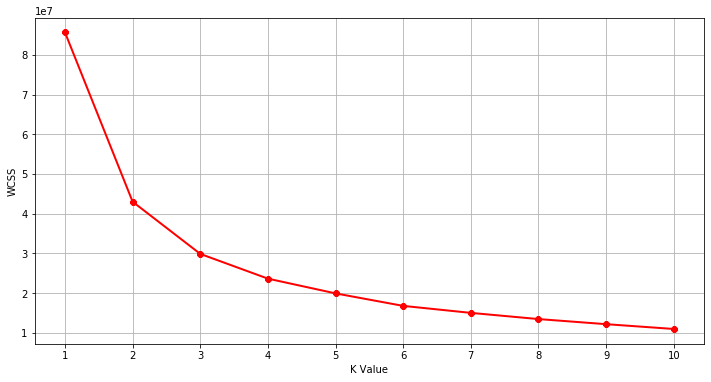

In [72]:
from sklearn.cluster import KMeans
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(agg2[shop_freq_cols])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

#### comment : it says 2 clusters are enough for this microsegment but I will create 3

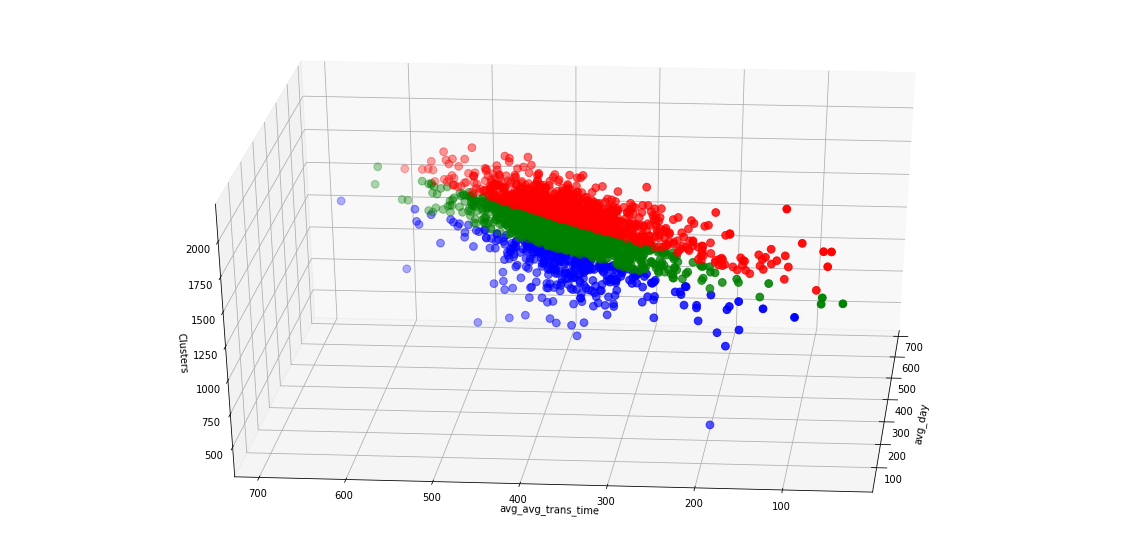

In [73]:
from sklearn import metrics
km = KMeans(n_clusters=3)
clusters = km.fit_predict(agg2[shop_freq_cols])
centers = km.cluster_centers_
agg2["Shop_Freq_Micro_Seg"] = clusters
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(agg2["avg_day"][agg2.Shop_Freq_Micro_Seg == 0], agg2["avg_day"][agg2.Shop_Freq_Micro_Seg == 0], agg2["avg_avg_trans_time"][agg2.Shop_Freq_Micro_Seg == 0], c='blue', s=60)
ax.scatter(agg2["avg_day"][agg2.Shop_Freq_Micro_Seg == 1], agg2["avg_day"][agg2.Shop_Freq_Micro_Seg == 1], agg2["avg_avg_trans_time"][agg2.Shop_Freq_Micro_Seg == 1], c='red', s=60)
ax.scatter(agg2["avg_day"][agg2.Shop_Freq_Micro_Seg == 2], agg2["avg_day"][agg2.Shop_Freq_Micro_Seg == 2], agg2["avg_avg_trans_time"][agg2.Shop_Freq_Micro_Seg == 2], c='green', s=60)
ax.view_init(30, 185)
plt.xlabel("avg_day")
plt.ylabel("avg_avg_trans_time")
ax.set_zlabel('Clusters')
plt.show()

In [74]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(agg2[shop_freq_cols], clusters)
agg2['Sample_Silhouette_Values'] = sample_silhouette_values
agg2.groupby(['Shop_Freq_Micro_Seg']).mean()['Sample_Silhouette_Values']

Shop_Freq_Micro_Seg
0   0.33455
1   0.37101
2   0.40311
Name: Sample_Silhouette_Values, dtype: float64

In [75]:
cluster_centers = []
for i in range(len(centers)):
    cluster_centers.append(np.sum(centers[i],axis=0) / len(centers))
    
cluster_centers

[548.6226550758623, 694.9893851671318, 635.2869655824255]

In [76]:
agg2.groupby(['Shop_Freq_Micro_Seg'])[shop_freq_cols].mean()

,avg_day,avg_avg_trans_time,avg_week_diff
Shop_Freq_Micro_Seg,,,
0,380.23079,1262.46919,2.73067
1,369.99977,1712.36407,2.28709
2,385.82825,1517.74905,1.99844


In [77]:
agg2.groupby(['Shop_Freq_Micro_Seg'])['household_key'].count()

Shop_Freq_Micro_Seg
0     349
1     977
2    1174
Name: household_key, dtype: int64

#### we can infer from that :
#### Shop_Freq_Micro_Seg = 0 : they like "buys in time of need" , they come to store at highest week difference level and spend minimum transaction time, buy things immediately and go out when needed
#### Shop_Freq_Micro_Seg = 1 : these customers are most valuable ones, They come to store in average week diff, spend maximum time in store
#### Shop_Freq_Micro_Seg = 2 : are most common customers that they comes to store more than others, with average 2 weeks period and average transaction time

In [78]:
agg2['Shop_Freq_Micro_Seg'] = np.where(agg2['Shop_Freq_Micro_Seg']==2,'common_customers',
                                      np.where(agg2['Shop_Freq_Micro_Seg']==0,'buy_when_need','attractive_ones'))

In [79]:
agg2.head()

,household_key,avg_day,avg_week,avg_basket_cnt,avg_avg_quantity,avg_avg_sales,avg_store_cnt,avg_retail_disc_mean,avg_avg_trans_time,avg_actual_prod_price,avg_avg_coupon_disc,avg_avg_coup_mdisc,most_freq_depart,most_freq_brand,most_freq_commodity,most_freq_camp,most_freq_display,most_freq_mailer,camp_date_exp,avg_week_diff,max_min_day_diff,max_min_week_diff,basket_range,quantity_range,avg_sales_range,Shop_Freq_Micro_Seg,Sample_Silhouette_Values
0,1,405.62821,58.62821,21.92308,1.15653,2.82369,1.00000,-0.38112,1421.25321,2.71843,-0.02854,-0.00986,GROCERY,National,BAKED BREAD/BUNS/ROLLS,TypeA,0,0,128,1.20513,655,94,53,1.00000,6.00607,common_customers,0.32920
1,2,323.00000,46.86667,15.84444,1.16919,3.25950,1.00000,-0.58534,1794.35556,3.22487,-0.02340,0.00000,GROCERY,National,BAKING MIXES,TypeA,0,0,76,1.80000,565,81,58,1.00000,16.74000,attractive_ones,0.53771
2,3,321.45652,46.58696,20.02174,152.62670,3.24732,1.00000,-0.66796,1657.62158,2.98179,-0.02127,-0.00655,GROCERY,National,BAG SNACKS,TypeA,0,0,196,1.82609,590,84,71,6948.00000,19.08188,attractive_ones,0.32436
3,4,330.46667,48.03333,10.00000,1.25754,4.07175,1.00000,-0.35053,1680.23333,3.73237,-0.00219,0.00000,GROCERY,National,FROZEN PIZZA,TypeA,0,0,46,2.46667,523,74,37,1.00000,8.96367,attractive_ones,0.43518
4,5,341.03030,49.42424,6.72727,1.09579,4.16093,1.00000,-0.45980,1773.41882,4.14532,0.00000,0.00000,GROCERY,National,ISOTONIC DRINKS,TypeA,0,0,12,2.66667,618,88,20,1.00000,15.49000,attractive_ones,0.55987


#### shop freq micro segments are done **

### create monetary behaviour microsegments

In [80]:
mon_behav_cols = ['avg_avg_quantity','avg_actual_prod_price','basket_range']

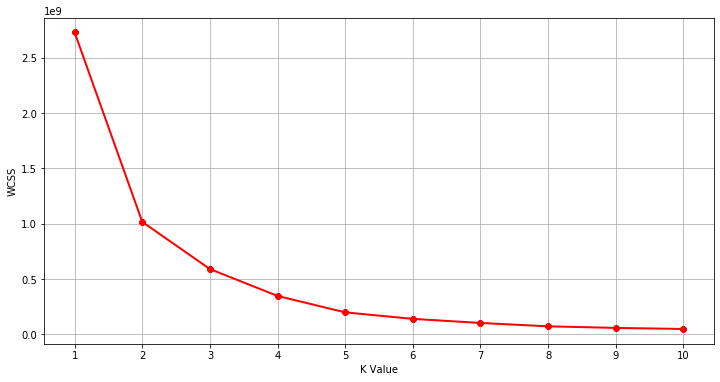

In [81]:
from sklearn.cluster import KMeans
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(agg2[mon_behav_cols])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

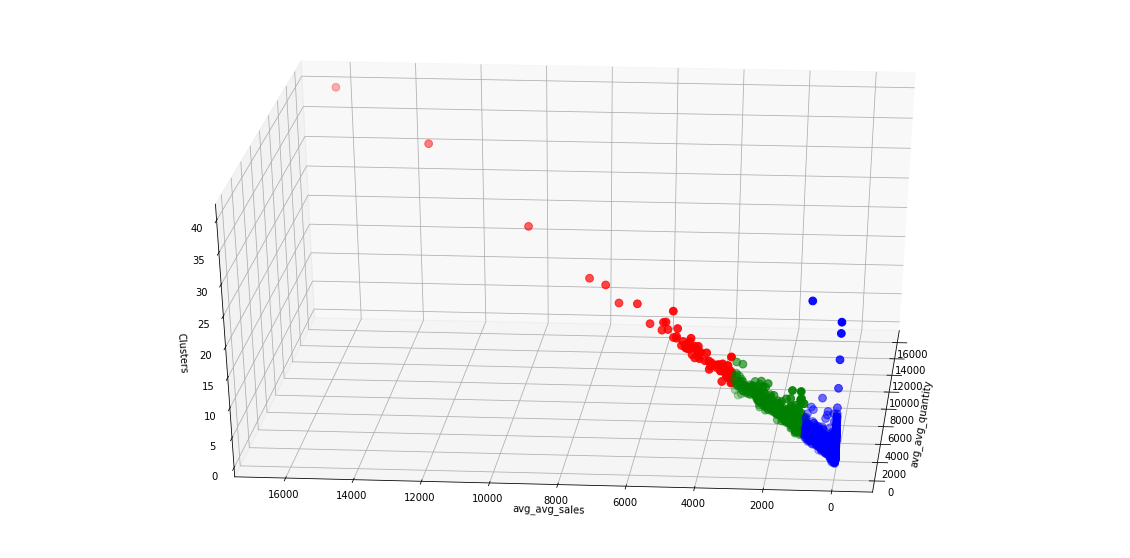

In [82]:
from sklearn import metrics
km = KMeans(n_clusters=3)
clusters = km.fit_predict(agg2[mon_behav_cols])
centers = km.cluster_centers_
agg2["Monetary_Micro_Seg"] = clusters
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(agg2["avg_avg_quantity"][agg2.Monetary_Micro_Seg == 0], agg2["avg_avg_quantity"][agg2.Monetary_Micro_Seg == 0], agg2["avg_avg_sales"][agg2.Monetary_Micro_Seg == 0], c='blue', s=60)
ax.scatter(agg2["avg_avg_quantity"][agg2.Monetary_Micro_Seg == 1], agg2["avg_avg_quantity"][agg2.Monetary_Micro_Seg == 1], agg2["avg_avg_sales"][agg2.Monetary_Micro_Seg == 1], c='red', s=60)
ax.scatter(agg2["avg_avg_quantity"][agg2.Monetary_Micro_Seg == 2], agg2["avg_avg_quantity"][agg2.Monetary_Micro_Seg == 2], agg2["avg_avg_sales"][agg2.Monetary_Micro_Seg == 2], c='green', s=60)
ax.view_init(30, 185)
plt.xlabel("avg_avg_quantity")
plt.ylabel("avg_avg_sales")
ax.set_zlabel('Clusters')
plt.show()

In [83]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(agg2[mon_behav_cols], clusters)
agg2['Sample_Silhouette_Values_Monetary'] = sample_silhouette_values
agg2.groupby(['Monetary_Micro_Seg']).mean()['Sample_Silhouette_Values_Monetary']

Monetary_Micro_Seg
0   0.82149
1   0.41860
2   0.49201
Name: Sample_Silhouette_Values_Monetary, dtype: float64

In [84]:
cluster_centers = []
for i in range(len(centers)):
    cluster_centers.append(np.sum(centers[i],axis=0) / len(centers))
    
cluster_centers

[68.48167955690413, 1590.5586180208722, 602.0742460021472]

#### comment : good seperation

In [85]:
agg2.groupby(['Monetary_Micro_Seg'])[mon_behav_cols].mean()

,avg_avg_quantity,avg_actual_prod_price,basket_range
Monetary_Micro_Seg,,,
0,155.72028,3.48203,47.02544
1,4698.34757,13.38463,59.94366
2,1746.73669,6.97711,56.35849


In [86]:
agg2.groupby(['Monetary_Micro_Seg'])['household_key'].count()

Monetary_Micro_Seg
0    2005
1      71
2     424
Name: household_key, dtype: int64

#### we can infer from that : 
#### Monetary_Micro_Seg = 0 : they are low segment customers with lowest monetary rates
#### Monetary_Micro_Seg = 1 : they are high segment customers with highest rates.
#### Monetary_Micro_Seg = 2 : mid segment customers due to monetarization that they buy avg quantitiy with avg price and also with avg basket range

#### I want to underline that, due to monetary segments, our customers are heavily involved in low segment (you can look at counts), there are so few high customers but we can focus on mid level customers I think

In [87]:
agg2['Monetary_Micro_Seg'] = np.where(agg2['Monetary_Micro_Seg']==0,'low',
                                      np.where(agg2['Monetary_Micro_Seg']==1,'high','mid'))

In [88]:
agg2.head()

,household_key,avg_day,avg_week,avg_basket_cnt,avg_avg_quantity,avg_avg_sales,avg_store_cnt,avg_retail_disc_mean,avg_avg_trans_time,avg_actual_prod_price,avg_avg_coupon_disc,avg_avg_coup_mdisc,most_freq_depart,most_freq_brand,most_freq_commodity,most_freq_camp,most_freq_display,most_freq_mailer,camp_date_exp,avg_week_diff,max_min_day_diff,max_min_week_diff,basket_range,quantity_range,avg_sales_range,Shop_Freq_Micro_Seg,Sample_Silhouette_Values,Monetary_Micro_Seg,Sample_Silhouette_Values_Monetary
0,1,405.62821,58.62821,21.92308,1.15653,2.82369,1.00000,-0.38112,1421.25321,2.71843,-0.02854,-0.00986,GROCERY,National,BAKED BREAD/BUNS/ROLLS,TypeA,0,0,128,1.20513,655,94,53,1.00000,6.00607,common_customers,0.32920,low,0.90351
1,2,323.00000,46.86667,15.84444,1.16919,3.25950,1.00000,-0.58534,1794.35556,3.22487,-0.02340,0.00000,GROCERY,National,BAKING MIXES,TypeA,0,0,76,1.80000,565,81,58,1.00000,16.74000,attractive_ones,0.53771,low,0.90278
2,3,321.45652,46.58696,20.02174,152.62670,3.24732,1.00000,-0.66796,1657.62158,2.98179,-0.02127,-0.00655,GROCERY,National,BAG SNACKS,TypeA,0,0,196,1.82609,590,84,71,6948.00000,19.08188,attractive_ones,0.32436,low,0.87510
3,4,330.46667,48.03333,10.00000,1.25754,4.07175,1.00000,-0.35053,1680.23333,3.73237,-0.00219,0.00000,GROCERY,National,FROZEN PIZZA,TypeA,0,0,46,2.46667,523,74,37,1.00000,8.96367,attractive_ones,0.43518,low,0.90409
4,5,341.03030,49.42424,6.72727,1.09579,4.16093,1.00000,-0.45980,1773.41882,4.14532,0.00000,0.00000,GROCERY,National,ISOTONIC DRINKS,TypeA,0,0,12,2.66667,618,88,20,1.00000,15.49000,attractive_ones,0.55987,low,0.90158


#### monetary microsegments are done **

### create campaign usage behaviour microsegments

In [89]:
camp_usage_cols= ['avg_retail_disc_mean','avg_avg_coupon_disc','avg_avg_coup_mdisc','camp_date_exp']

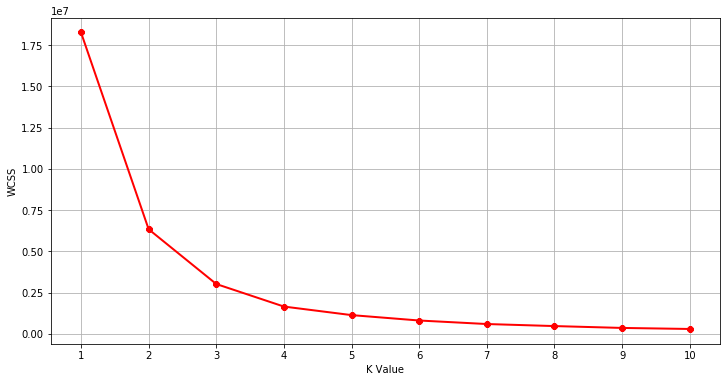

In [90]:
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(agg2[camp_usage_cols])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

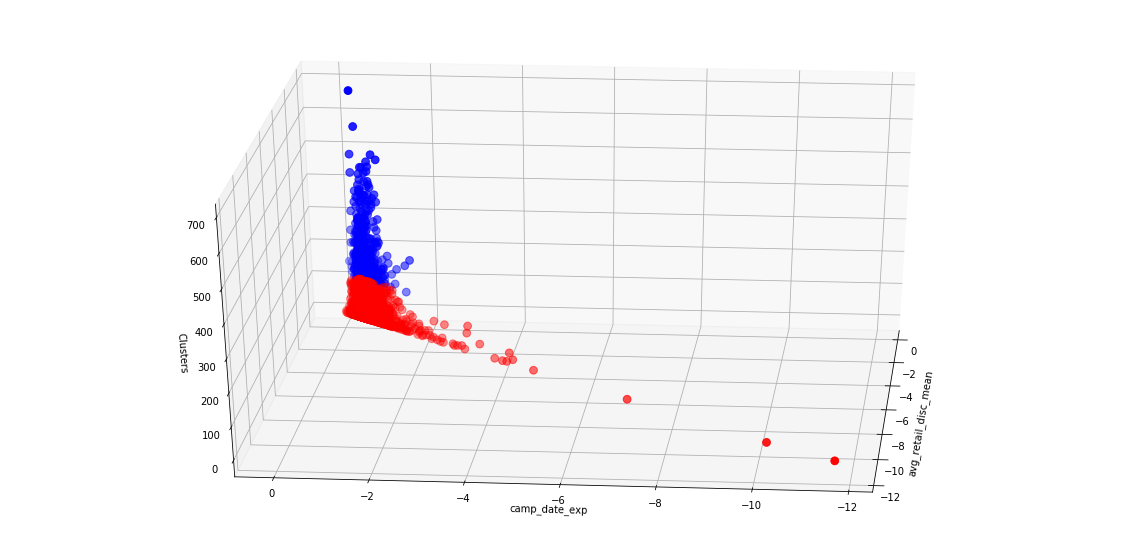

In [91]:
from sklearn import metrics
km = KMeans(n_clusters=2)
clusters = km.fit_predict(np.abs(agg2[camp_usage_cols]))
centers = km.cluster_centers_
agg2["Campaign_Use_Micro_Seg"] = clusters
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(agg2["avg_retail_disc_mean"][agg2.Campaign_Use_Micro_Seg == 0], agg2["avg_retail_disc_mean"][agg2.Campaign_Use_Micro_Seg == 0], agg2["camp_date_exp"][agg2.Campaign_Use_Micro_Seg == 0], c='blue', s=60)
ax.scatter(agg2["avg_retail_disc_mean"][agg2.Campaign_Use_Micro_Seg == 1], agg2["avg_retail_disc_mean"][agg2.Campaign_Use_Micro_Seg == 1], agg2["camp_date_exp"][agg2.Campaign_Use_Micro_Seg == 1], c='red', s=60)
#ax.scatter(agg2["avg_retail_disc_mean"][agg2.Campaign_Use_Micro_Seg == 2], agg2["avg_retail_disc_mean"][agg2.Campaign_Use_Micro_Seg == 2], agg2["camp_date_exp"][agg2.Campaign_Use_Micro_Seg == 2], c='green', s=60)
ax.view_init(30, 185)
plt.xlabel("avg_retail_disc_mean")
plt.ylabel("camp_date_exp")
ax.set_zlabel('Clusters')
plt.show()

In [92]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(agg2[camp_usage_cols], clusters)
agg2['Sample_Silhouette_Values_Cmap'] = sample_silhouette_values
agg2.groupby(['Campaign_Use_Micro_Seg']).mean()['Sample_Silhouette_Values_Cmap']

Campaign_Use_Micro_Seg
0   0.47243
1   0.72852
Name: Sample_Silhouette_Values_Cmap, dtype: float64

In [93]:
cluster_centers = []
for i in range(len(centers)):
    cluster_centers.append(np.sum(centers[i],axis=0) / len(centers))
    
cluster_centers

[102.18669793292828, 18.964104995793104]

In [94]:
agg2.groupby(['Campaign_Use_Micro_Seg'])[camp_usage_cols].mean()

,avg_retail_disc_mean,avg_avg_coupon_disc,avg_avg_coup_mdisc,camp_date_exp
Campaign_Use_Micro_Seg,,,,
0,-0.57060,-0.01257,-0.00219,203.78804
1,-0.61586,-0.00920,-0.00130,37.30185


In [95]:
agg2.groupby(['Campaign_Use_Micro_Seg'])['household_key'].count()

Campaign_Use_Micro_Seg
0     552
1    1948
Name: household_key, dtype: int64

#### we can infer from that :
#### Campaign_Use_Micro_Seg = 0 : are the common campaign follower and discounter customers
#### Campaign_Use_Micro_Seg = 1 : most advantegous population that they have have low campaign exposure but highest retail discount

In [96]:
agg2['Campaign_Use_Micro_Seg'] = np.where(agg2['Campaign_Use_Micro_Seg']==0,'common_campaigner','chancer_camp')

In [97]:
agg2.head()

,household_key,avg_day,avg_week,avg_basket_cnt,avg_avg_quantity,avg_avg_sales,avg_store_cnt,avg_retail_disc_mean,avg_avg_trans_time,avg_actual_prod_price,avg_avg_coupon_disc,avg_avg_coup_mdisc,most_freq_depart,most_freq_brand,most_freq_commodity,most_freq_camp,most_freq_display,most_freq_mailer,camp_date_exp,avg_week_diff,max_min_day_diff,max_min_week_diff,basket_range,quantity_range,avg_sales_range,Shop_Freq_Micro_Seg,Sample_Silhouette_Values,Monetary_Micro_Seg,Sample_Silhouette_Values_Monetary,Campaign_Use_Micro_Seg,Sample_Silhouette_Values_Cmap
0,1,405.62821,58.62821,21.92308,1.15653,2.82369,1.00000,-0.38112,1421.25321,2.71843,-0.02854,-0.00986,GROCERY,National,BAKED BREAD/BUNS/ROLLS,TypeA,0,0,128,1.20513,655,94,53,1.00000,6.00607,common_customers,0.32920,low,0.90351,common_campaigner,0.15687
1,2,323.00000,46.86667,15.84444,1.16919,3.25950,1.00000,-0.58534,1794.35556,3.22487,-0.02340,0.00000,GROCERY,National,BAKING MIXES,TypeA,0,0,76,1.80000,565,81,58,1.00000,16.74000,attractive_ones,0.53771,low,0.90278,chancer_camp,0.63588
2,3,321.45652,46.58696,20.02174,152.62670,3.24732,1.00000,-0.66796,1657.62158,2.98179,-0.02127,-0.00655,GROCERY,National,BAG SNACKS,TypeA,0,0,196,1.82609,590,84,71,6948.00000,19.08188,attractive_ones,0.32436,low,0.87510,common_campaigner,0.62444
3,4,330.46667,48.03333,10.00000,1.25754,4.07175,1.00000,-0.35053,1680.23333,3.73237,-0.00219,0.00000,GROCERY,National,FROZEN PIZZA,TypeA,0,0,46,2.46667,523,74,37,1.00000,8.96367,attractive_ones,0.43518,low,0.90409,chancer_camp,0.79336
4,5,341.03030,49.42424,6.72727,1.09579,4.16093,1.00000,-0.45980,1773.41882,4.14532,0.00000,0.00000,GROCERY,National,ISOTONIC DRINKS,TypeA,0,0,12,2.66667,618,88,20,1.00000,15.49000,attractive_ones,0.55987,low,0.90158,chancer_camp,0.83424


#### campaign usage microsegments are done **

### create buying behaviour clusters

In [98]:
buy_behave_cols = ['most_freq_depart','most_freq_brand','most_freq_commodity','most_freq_camp']

In [127]:
# define the k-modes model
km = KModes(n_clusters=5, init='Huang', n_init=11, verbose=1)
# fit the clusters to the skills dataframe
clusters = km.fit_predict(agg2[buy_behave_cols])
agg2["Buying_Micro_Seg"] = clusters
# get an array of cluster modes
kmodes = km.cluster_centroids_
shape = kmodes.shape

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 1823.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 1919.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 8, cost: 1881.0
Run 4, iteration: 2/100, moves: 0, cost: 1881.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 1704.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 0, cost: 2012.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 0, cost: 1813.0
Init: initializing centroids
Init: initializing clusters

In [128]:
kmodes

array([['GROCERY', 'National', 'COUPON/MISC ITEMS', 'TypeA'],
       ['GROCERY', 'National', 'BAG SNACKS', 'TypeA'],
       ['GROCERY', 'National', 'SOFT DRINKS', 'TypeA'],
       ['GROCERY', 'National', 'BEERS/ALES', 'TypeA'],
       ['GROCERY', 'National', 'BAKED BREAD/BUNS/ROLLS', 'TypeA']],
      dtype='<U22')

In [ ]:
agg2.head()

In [129]:
agg2['Buying_Micro_Seg'] = np.where(agg2['Buying_Micro_Seg']==0,'campaigners',
                                    np.where(agg2['Buying_Micro_Seg']==1,'outdoor',
                                             np.where(agg2['Buying_Micro_Seg']==2,'soft drinkers',
                                                      np.where(agg2['Buying_Micro_Seg']==3,'beer lovers',
                                                               np.where(agg2['Buying_Micro_Seg']==4,'baked','none')))))

In [130]:
agg2.groupby(['Buying_Micro_Seg'])['household_key'].count()

Buying_Micro_Seg
baked             296
beer lovers        56
campaigners      1657
outdoor           219
soft drinkers     272
Name: household_key, dtype: int64

In [107]:
agg2.head()

,household_key,avg_day,avg_week,avg_basket_cnt,avg_avg_quantity,avg_avg_sales,avg_store_cnt,avg_retail_disc_mean,avg_avg_trans_time,avg_actual_prod_price,avg_avg_coupon_disc,avg_avg_coup_mdisc,most_freq_depart,most_freq_brand,most_freq_commodity,most_freq_camp,most_freq_display,most_freq_mailer,camp_date_exp,avg_week_diff,max_min_day_diff,max_min_week_diff,basket_range,quantity_range,avg_sales_range,Shop_Freq_Micro_Seg,Sample_Silhouette_Values,Monetary_Micro_Seg,Sample_Silhouette_Values_Monetary,Campaign_Use_Micro_Seg,Sample_Silhouette_Values_Cmap,Buying_Micro_Seg
0,1,405.62821,58.62821,21.92308,1.15653,2.82369,1.00000,-0.38112,1421.25321,2.71843,-0.02854,-0.00986,GROCERY,National,BAKED BREAD/BUNS/ROLLS,TypeA,0,0,128,1.20513,655,94,53,1.00000,6.00607,common_customers,0.32920,low,0.90351,common_campaigner,0.15687,baked
1,2,323.00000,46.86667,15.84444,1.16919,3.25950,1.00000,-0.58534,1794.35556,3.22487,-0.02340,0.00000,GROCERY,National,BAKING MIXES,TypeA,0,0,76,1.80000,565,81,58,1.00000,16.74000,attractive_ones,0.53771,low,0.90278,chancer_camp,0.63588,campaigners
2,3,321.45652,46.58696,20.02174,152.62670,3.24732,1.00000,-0.66796,1657.62158,2.98179,-0.02127,-0.00655,GROCERY,National,BAG SNACKS,TypeA,0,0,196,1.82609,590,84,71,6948.00000,19.08188,attractive_ones,0.32436,low,0.87510,common_campaigner,0.62444,outdoor
3,4,330.46667,48.03333,10.00000,1.25754,4.07175,1.00000,-0.35053,1680.23333,3.73237,-0.00219,0.00000,GROCERY,National,FROZEN PIZZA,TypeA,0,0,46,2.46667,523,74,37,1.00000,8.96367,attractive_ones,0.43518,low,0.90409,chancer_camp,0.79336,campaigners
4,5,341.03030,49.42424,6.72727,1.09579,4.16093,1.00000,-0.45980,1773.41882,4.14532,0.00000,0.00000,GROCERY,National,ISOTONIC DRINKS,TypeA,0,0,12,2.66667,618,88,20,1.00000,15.49000,attractive_ones,0.55987,low,0.90158,chancer_camp,0.83424,campaigners


#### buying behavior microsegments are done **

In [131]:
microseg_col = ['Shop_Freq_Micro_Seg','Monetary_Micro_Seg','Campaign_Use_Micro_Seg','Buying_Micro_Seg']

In [132]:
macro = agg2.groupby(microseg_col)['household_key'].count().reset_index().rename(columns={'household_key':'count'})

In [133]:
macro.sort_values(by='count')

,Shop_Freq_Micro_Seg,Monetary_Micro_Seg,Campaign_Use_Micro_Seg,Buying_Micro_Seg,count
24,buy_when_need,high,common_campaigner,outdoor,1
60,common_customers,mid,common_campaigner,beer lovers,1
22,buy_when_need,high,common_campaigner,beer lovers,1
19,attractive_ones,mid,common_campaigner,outdoor,1
55,common_customers,mid,chancer_camp,beer lovers,1
37,buy_when_need,mid,chancer_camp,soft drinkers,1
8,attractive_ones,low,common_campaigner,beer lovers,1
17,attractive_ones,mid,common_campaigner,baked,1
41,common_customers,high,chancer_camp,baked,1
38,buy_when_need,mid,common_campaigner,baked,2


### conclusion : we can manage these microsegments for different marketing purposes

### Thanks Hincal Topcuoglu